## Import Library

In [ ]:
from datetime import datetime

import logging
import re

# visualize
import seaborn as sns
from yellowbrick.features import PCA as yellowPCA

# Data preprocessing
import hdbscan
import umap
import os
import re
import emoji
from collections import Counter
import sys
import time
import nltk
from nltk.tokenize import word_tokenize

# for transformer 
from soynlp.normalizer import repeat_normalize
from soynlp.normalizer import *
from soynlp.noun import NewsNounExtractor
from transformers import BertModel, BertTokenizer, AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
import gluonnlp as nlp
from kobert.pytorch_kobert import get_pytorch_kobert_model
from kobert.utils import get_tokenizer
from kobert_tokenizer import KoBERTTokenizer
from pytorch_transformers import BertTokenizer, BertForSequenceClassification, BertConfig

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

# torch library
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from sklearn.metrics import f1_score, accuracy_score

import warnings
warnings.filterwarnings(action='ignore')

In [51]:
device = torch.device("cuda:0")

## Data load & Preprocessing

In [52]:
# Data Loading to clustering

root_path = os.getcwd()
print(root_path)
dir_path = root_path +'/news_data_bigkinds_221004.csv'

df = pd.read_csv(dir_path, encoding='cp949')
df.head()

/nas1/yongk/bigkinds


,title,hilight,provider,category,byline,target
0,힌지 줄이고 배터리 3시간 늘렸다...갤럭시Z4 '디테일 승부수',힌지 줄이고 배터리 3시간 늘렸다...갤럭시Z4 ..'디테일 승부수' ..“뭐가 바...,중앙일보,['IT_과학>모바일'],고석현(ko.sukhyun@joongang.co.kr),1
1,"힌지 주름 줄이고 가볍게…""폴더블폰 완성작""","힌지 주름 줄이고 가볍게…""폴더블폰 완성작"" ..“비슷한데 더 섬세해졌다.” .. ...",한국경제,"['IT_과학>모바일', 'IT_과학>콘텐츠']",배성수 /정지은,1
2,힌지 주름 어디 갔지?… 삼성 “폴더블폰 대중화”,힌지 주름 어디 갔지?… 삼성 ..“폴더블폰 대중화” 삼성전자가 9일(현지 시간) ...,동아일보,['IT_과학>모바일'],곽도영,1
3,"힌지 얇아지고, 가로 넓어지고…확 달라진 갤폴드4 이런 모습?","힌지 얇아지고, 가로 넓어지고…확 달라진 갤폴드4 이런 모습? ..“폴드4가 폴드3...",중앙일보,"['IT_과학>모바일', '경제>유통', '경제>반도체']",이수정(lee.sujeong1@joongang.co.kr),1
4,"흑화당, '오로라 곤약 버블티' 출시","흑화당, ..'오로라 곤약 버블티' 출시 프리미엄 티 하우스 흑화당이 한 여름밤의 ...",아시아경제,['IT_과학>IT_과학일반'],정진,1


In [53]:
def preprocess_data(data, data_colname):
    """
      tips: csv 데이터를 받아 지정된 column의 내용을 preprocess 합니다.
      Args:
          data_path : csv데이터의 path
          data_colname : 지정할 column명
      Returns:
          lucy_data : DataFrame
    """
    lucy_data = data

    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\(.*\)|\s-\s.*"," " ,regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\[.*\]|\s-\s.*"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\<.*\>|\s-\s.*"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("무단전재 및 재배포 금지"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("무단 전재 및 재배포 금지"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("©"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("ⓒ"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("저작권자"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace(".* 기자", " ", regex=True) #기자 이름에서 오는 유사도 차단
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("사진 = .*", " ", regex=True) #사진 첨부 문구 삭제
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("사진=.*", " ", regex=True) #사진 첨부 문구 삭제
    lucy_data[data_colname] = lucy_data[data_colname].str.replace('\"', "",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+.[a-zA-Z0-9-.]+)", " ", regex=True) #이메일 주소에서 오는 유사도 차단
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\n"," ")
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\r"," ")
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\t"," ")
    lucy_data[data_colname] = lucy_data[data_colname].str.replace( "\’" , "", regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("[ ]{2,}"," ",regex=True)
    
    return lucy_data

In [54]:
# Data preprocessing
df.byline = df.byline.str[:3]
df.category = df.category.str[:10]
clean_data = preprocess_data(df, 'title')
clean_data = preprocess_data(clean_data, 'hilight')
clean_data = preprocess_data(clean_data, 'byline')
clean_data.category = clean_data.category.str[2:]
clean_data['category'] = clean_data['category'].str.replace(">"," ")

In [55]:
clean_data.head()

,title,hilight,provider,category,byline,target
0,힌지 줄이고 배터리 시간 늘렸다 갤럭시 디테일 승부수,힌지 줄이고 배터리 시간 늘렸다 갤럭시 디테일 승부수 뭐가 바뀌었냐고 뚜껑 열기 전...,중앙일보,IT_과학 모바,고석현,1
1,힌지 주름 줄이고 가볍게 폴더블폰 완성작,힌지 주름 줄이고 가볍게 폴더블폰 완성작 비슷한데 더 섬세해졌다 삼성전자가 일 에 ...,한국경제,IT_과학 모바,배성수,1
2,힌지 주름 어디 갔지 삼성 폴더블폰 대중화,힌지 주름 어디 갔지 삼성 폴더블폰 대중화 삼성전자가 일 년 개월 만의 갤럭시 언팩...,동아일보,IT_과학 모바,곽도영,1
3,힌지 얇아지고 가로 넓어지고 확 달라진 갤폴드 이런 모습,힌지 얇아지고 가로 넓어지고 확 달라진 갤폴드 이런 모습 폴드 가 폴드 와 매우 유...,중앙일보,IT_과학 모바,이수정,1
4,흑화당 오로라 곤약 버블티 출시,흑화당 오로라 곤약 버블티 출시 프리미엄 티 하우스 흑화당이 한 여름밤의 오로라를 ...,아시아경제,IT_과학 IT,정진,1


In [56]:
# Category labeling
label_dict = {'0': 'IT_과학',
      '1': '경제',
      '2': '문화',
      '3': '지역',
      '4': '사회',
      '5': '국제',
      '6': '스포츠',
      '7': '정치'}

for key, value in label_dict.items():
    print(value)
    clean_data['category'] = clean_data['category'].str.replace(value, key)


IT_과학
경제
문화
지역
사회
국제
스포츠
정치


In [57]:
clean_data[5000:5100]

,title,hilight,provider,category,byline,target
5000,통화하며 벌벌 떠는 노인 본 경찰 쪽지 한장 으로 검거 작전,통화하며 벌벌 떠는 노인 본 경찰 쪽지 한장 으로 검거 작전 대 노인에게 현금 만원...,머니투데이,4 사건_사고,윤세미,0
5001,통화녹음하면 징역 년 그럼 갤럭시 안 쓰지 삼전 타격 받나,통화녹음하면 징역 년 그럼 갤럭시 안 쓰지 삼전 타격 받나 당사자 간의 통화나 대화...,머니투데이,0 보안,홍효진,0
5002,통화 도중 내가 녹음해도 불법 과도한 규제 음성권 보장,통화 도중 내가 녹음해도 불법 과도한 규제 음성권 보장 메모지와 볼펜을 찾기 귀찮아...,아시아경제,7 행정_자치,임혜선,0
5003,통합관제센터 찾은 김태우 서울 강서구청장,통합관제센터 찾은 김태우 서울 강서구청장 통합관제시스템을 기반으로 더욱 촘촘한 사회...,서울신문,0 모바,이두걸,0
5004,통합 전기차 충전 플랫폼 채비 코리아빌드 전기차 충전인프라 산업전 참가한다,통합 전기차 충전 플랫폼 채비 코리아빌드 전기차 충전인프라 산업전 참가한다 통합 전...,서울경제,"1 자동차',",김동호,0
...,...,...,...,...,...,...
5095,토스 해외주식 시장점유율 돌파,토스 해외주식 시장점유율 돌파 토스증권은 해외주식 시장점유율이 를 돌파했다고 일 밝...,한국경제,1 증권_증시,이슬기,0
5096,토스앱서 휴대폰 개통 가능해진다 알뜰폰 업계 부글부글,토스앱서 휴대폰 개통 가능해진다 알뜰폰 업계 부글부글 모바일 금융 서비스 토스 를 ...,한국경제,"1 유통',",조아라,0
5097,토스뱅크 카뱅 이어 플랫폼으로 한발짝 금융상품 광고한다,토스뱅크 카뱅 이어 플랫폼으로 한발짝 금융상품 광고한다 토스뱅크가 금융 플랫폼으로서...,헤럴드경제,1 금융_재테,박자연,0
5098,토스뱅크 카드업계 반발에 카드론 대환대출 잠정 중단,토스뱅크 카드업계 반발에 카드론 대환대출 잠정 중단 토스뱅크가 고금리 카드론을 토스...,동아일보,1 금융_재테,송혜미,0


In [58]:
clean_data_pre = clean_data[['title', 'hilight', 'target']]
cleand_data_adto = clean_data_pre.loc[clean_data_pre['target']==1]
cleand_data_real = clean_data_pre.loc[clean_data_pre['target']==0]

noun_extractor = NewsNounExtractor()

used default noun predictor; Sejong corpus based logistic predictor
/home/yongk/anaconda3/envs/BK/lib/python3.8/site-packages/soynlp
local variable 'f' referenced before assignment
local variable 'f' referenced before assignment


In [59]:
# set-up empty dataframe
news_data = pd.DataFrame()
adto_data = pd.DataFrame()
real_data = pd.DataFrame()

# Total news data
news_data["content"] = clean_data_pre["title"] + clean_data_pre["hilight"]
news_data["target"] =  clean_data_pre["target"]

# adtorial news data
adto_data["content"] = cleand_data_adto["title"] + cleand_data_adto["hilight"]
adto_data["target"] =  cleand_data_adto["target"]

# real news data
real_data["content"] = cleand_data_real["title"] + cleand_data_real["hilight"]
real_data["target"] =  cleand_data_real["target"]

# transformation to array
total_x = news_data.content
adto_x = adto_data.content
real_x = real_data.content

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
with open('/nas1/yongk/bigkinds/stopwords.txt', 'r', encoding='utf-8') as f:
    list_file = f.read().splitlines()

stopwords = list_file

tfidf = TfidfVectorizer(stop_words=stopwords)
news_data["content"] = news_data["content"].fillna('')

In [61]:
news_data

,content,target
0,힌지 줄이고 배터리 시간 늘렸다 갤럭시 디테일 승부수 힌지 줄이고 배터리 시간 늘렸...,1
1,힌지 주름 줄이고 가볍게 폴더블폰 완성작힌지 주름 줄이고 가볍게 폴더블폰 완성작 비...,1
2,힌지 주름 어디 갔지 삼성 폴더블폰 대중화 힌지 주름 어디 갔지 삼성 폴더블폰 대중...,1
3,힌지 얇아지고 가로 넓어지고 확 달라진 갤폴드 이런 모습 힌지 얇아지고 가로 넓어지...,1
4,흑화당 오로라 곤약 버블티 출시흑화당 오로라 곤약 버블티 출시 프리미엄 티 하우스 ...,1
...,...,...
10326,번호도 주의 억 가로챈 보이스피싱 일당 명 적발 번호도 주의 억 가로챈 보이스피싱...,0
10327,씨 아닌데요 문자 전화 스트레스 통신사 안내 법제화 추진 씨 아닌데요 문자 전화 ...,0
10328,지검 검사입니다 생전 처음 듣는 강압적 목소리에 속았다 지검 검사입니다 생전 처음...,0
10329,천만 년 후 화성도 토성처럼 변한다 천만 년 후 화성도 토성처럼 변한다 년 전 ...,0


In [62]:
tfidf.fit(news_data["content"])
tfidf_matrix = tfidf.transform(news_data["content"])
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [63]:
indices = pd.Series(clean_data_pre.index, index=clean_data_pre['title']).drop_duplicates()

In [64]:
def get_recommendations(title, cosine_sim = cosine_sim):
    idx = indices[title]
    
    # 모든 기사에 대해서 해당 기사의 유사도를 구한다.
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # 유사도에 따라 기사들을 정렬한다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # 가장 유사한 10개의 기사를 받아온다.
    sim_scores = sim_scores[1:11]
    
    # 가장 유사한 10개의 기사의 인덱스를 받아온다.
    movie_indices = [i[0] for i in sim_scores]
    
    # 가장 유사한 10개의 기사의 제목을 리턴한다.
    return clean_data_pre['title'].iloc[movie_indices]

In [65]:
noun_extractor = NewsNounExtractor()

# 1. 광고성 기사 관련한 명사 추출하기
adto_data_word = noun_extractor.train_extract(adto_x)
adto_data_word
#adto_freq = {word:NewsNounScore.frequency for word, NewsNounScore in adto_data_word.items()}
#sorted_adto_freq = sorted(adto_freq.items(), key = lambda item : item[1], reverse = True)
#sorted_adto_freq

used default noun predictor; Sejong corpus based logistic predictor
/home/yongk/anaconda3/envs/BK/lib/python3.8/site-packages/soynlp
local variable 'f' referenced before assignment
local variable 'f' referenced before assignment
scan vocabulary ... 
done (Lset, Rset, Eojeol) = (38640, 24172, 21001)
predicting noun score was done                                        
before postprocessing 10952
_noun_scores_ 2666
checking hardrules ... done / 2666떡볶+(이)), NVsubE (사기(당)+했다) ... done
after postprocessing 1807
extracted 82 compounds from eojeolss ... 2000 / 2871

[('서비스', 705),
 ('개발', 533),
 ('출시', 467),
 ('플랫폼', 381),
 ('투자', 373),
 ('국내', 362),
 ('기술', 347),
 ('삼성', 311),
 ('디지털', 289),
 ('지난', 258),
 ('글로벌', 255),
 ('스마트', 245),
 ('시장', 228),
 ('스타트업', 220),
 ('공개', 218),
 ('치료제', 216),
 ('사업', 208),
 ('코로나', 207),
 ('미래', 202),
 ('한국', 199),
 ('메타', 196),
 ('세계', 193),
 ('최초', 192),
 ('이번', 189),
 ('아이', 187),
 ('프로', 182),
 ('연구', 177),
 ('기반', 175),
 ('미국', 161),
 ('콘텐츠', 160),
 ('강화', 157),
 ('대상', 154),
 ('솔루션', 153),
 ('고객', 152),
 ('로봇', 149),
 ('모바일', 148),
 ('메타버스', 147),
 ('게임', 147),
 ('공동', 144),
 ('전기', 143),
 ('운영', 137),
 ('개최', 136),
 ('삼성전자', 132),
 ('협력', 131),
 ('구축', 131),
 ('금융', 130),
 ('데이터', 129),
 ('지원', 128),
 ('억원', 125),
 ('판매', 125),
 ('가상', 123),
 ('정보', 119),
 ('오픈', 116),
 ('전기차', 116),
 ('올해', 113),
 ('최대', 112),
 ('대출', 111),
 ('계약', 108),
 ('도입', 106),
 ('사용', 105),
 ('인증', 103),
 ('애플', 103),
 ('업무협약', 102),
 ('특허', 102),
 ('분야', 102),
 ('신약', 101),
 ('획득', 100),
 ('온라인', 100),
 ('현대자동차', 99),
 ('규모', 98)

In [67]:
# 2. 일반 기사 관련 명사 추출
real_data_word = noun_extractor.train_extract(real_x)
real_data_word
#real_freq = {word:NewsNounScore.frequency for word, NewsNounScore in real_data_word.items()}
#sorted_real_freq = sorted(real_freq.items(), key = lambda item : item[1], reverse = True)
#sorted_real_freq

scan vocabulary ... 
done (Lset, Rset, Eojeol) = (133253, 80944, 73425)
predicting noun score was done                                        0
before postprocessing 38683
_noun_scores_ 8921
checking hardrules ... done / 8921떡볶+(이)), NVsubE (사기(당)+했다) ... done
after postprocessing 6251
extracted 2 compounds from eojeolss ... 10000 / 10530

{'간편결제': NewsNounScore(score=-0.619916, frequency=33, feature_proportion=0.2, eojeol_proportion=0.8484848484848485, n_positive_feature=0, unique_positive_feature_proportion=0.0),
 '건강기능식품': NewsNounScore(score=0, frequency=10, feature_proportion=0, eojeol_proportion=1.0, n_positive_feature=0, unique_positive_feature_proportion=0),
 '섬유소재': NewsNounScore(score=0, frequency=0, feature_proportion=0, eojeol_proportion=0, n_positive_feature=0, unique_positive_feature_proportion=0),
 '품질고도화': NewsNounScore(score=0, frequency=0, feature_proportion=0, eojeol_proportion=0, n_positive_feature=0, unique_positive_feature_proportion=0),
 '심리상담': NewsNounScore(score=0.99961, frequency=2, feature_proportion=1.0, eojeol_proportion=0.0, n_positive_feature=1, unique_positive_feature_proportion=1.0),
 '성장관리': NewsNounScore(score=0, frequency=0, feature_proportion=0, eojeol_proportion=0, n_positive_feature=0, unique_positive_feature_proportion=0),
 '훈련과정': NewsNounScore(score=0, frequency=0, feature_propo

In [18]:
clean_data.category = clean_data.category.str[:1]

In [19]:
real_data_list = []
for q, label in zip(news_data['content'], news_data['target']):
    data = []
    data.append(q)
    data.append(str(label))
    
    real_data_list.append(data)

### Config

In [20]:
# argment

max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate = 0.00006

### Set Dataloader

In [21]:
# train / test split
# For BERT
BERT_train_dataset, BERT_test_dataset = train_test_split(news_data, test_size = 0.25, random_state=0, shuffle=True)

# For KoBERT
KoBERT_train_dataset, KoBERT_test_dataset = train_test_split(real_data_list, test_size = 0.25, random_state=0, shuffle=True)

In [22]:
# KoBERT Dataloader
class KoBERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
                bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]
        
    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
    
    def __len__(self):
        return (len(self.labels))

In [23]:
class NsmcDataset(Dataset):
    ''' News bigkinds Corpus Dataset '''
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]
        return text, label

In [24]:
# BERT Dataloader

nsmc_train_dataset = NsmcDataset(BERT_train_dataset)
nsmc_test_dataset = NsmcDataset(BERT_test_dataset)
BERT_train_loader = DataLoader(nsmc_train_dataset, batch_size=batch_size, shuffle=True, num_workers=5)
BERT_test_loader = DataLoader(nsmc_test_dataset, batch_size=batch_size, shuffle=True, num_workers=5)

In [25]:
# import pretrained kobert

bertmodel, vocab = get_pytorch_kobert_model()
KoBERT_tokenizer = get_tokenizer()
BERT_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
tok = nlp.data.BERTSPTokenizer(KoBERT_tokenizer, vocab, lower=False)

using cached model. /nas1/yongk/bigkinds/.cache/kobert_v1.zip
using cached model. /nas1/yongk/bigkinds/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /nas1/yongk/bigkinds/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [26]:
# KoBERT Dataloader

data_train = KoBERTDataset(KoBERT_train_dataset, 0, 1, tok, max_len, True, False)
data_test = KoBERTDataset(KoBERT_test_dataset, 0, 1, tok, max_len, True, False)
KoBERT_train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=5)
KoBERT_test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=True, num_workers=5)

In [70]:
data_train[0]

(array([   2, 4128, 5706, 6596, 4665, 6079, 5655, 4619, 7234, 1233, 2658,
        3765, 2957, 7234, 5706, 6596, 4665, 6079, 5655, 4619, 7234, 1233,
        2658, 3765, 2957, 4128, 5706, 6596, 7086,  953, 5495, 7003,  517,
        7079, 2957, 6292, 5439, 3803, 2261, 4128, 5706, 6596, 7086, 5064,
        1562, 5504, 5087, 4665, 6079, 5655, 4619, 7234, 7095, 3826, 6531,
        4370, 4274, 4306,  517, 7028, 1139, 2012, 2957,    3], dtype=int32),
 array(64, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 1)

## Modeling

In [27]:
class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size = 768, num_classes = 1, dr_rate = 0.2, params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        
        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        
        return attention_mask.float()
    
    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        
        if self.dr_rate:
            out = self.dropout(pooler)
            
        return self.classifier(out)

### Utils

In [28]:
# Accuracy

def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    
    return train_acc

In [29]:
# For training

class AverageMeter(object):
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.sum = 0
        self.count = 0
        self.avg = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = f'{self.name:10s} {self.avg:.8f}'
        return fmtstr

class ProgressMeter(object):
    def __init__(self, meters, loader_length, prefix=""):
        self.meters = [AverageMeter(i) for i in meters]
        self.loader_length = loader_length
        self.prefix = prefix
    
    def reset(self):
        for m in self.meters:
            m.reset()
    
    def update(self, values, n=1):
        for m, v in zip(self.meters, values):
            m.update(v, n)
            self.__setattr__(m.name, m.avg)

    def display(self, batch_idx, postfix=""):
        batch_info = f'[{batch_idx+1:03d}/{self.loader_length:03d}]'
        msg = [self.prefix + ' ' + batch_info]
        msg += [str(meter) for meter in self.meters]
        msg = ' | '.join(msg)

        sys.stdout.write('\r')
        sys.stdout.write(msg + postfix)
        sys.stdout.flush()

## KoBERT

In [83]:
model = BERTClassifier(bertmodel, dr_rate = 0.2).to(device)

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params':[p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params':[p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

t_total = len(KoBERT_train_loader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [87]:
class Trainer(object):
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.best_epoch, self.best_accuracy = 0, 0
    
    def train(self, train_loader, epoch):
        progress = ProgressMeter(["train_loss", "train_acc"], len(train_loader), prefix=f'EPOCH {epoch:03d}')
        self.model.train()
        start_time = time.time()
        
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_loader)):
            self.optimizer.zero_grad()
            
            label = label.unsqueeze(1)
            label = label.float().to(device)
            token_ids, valid_length, segment_ids, label = token_ids.float().to(self.device), valid_length.to(self.device), segment_ids.float().to(self.device), label.float().to(self.device)
            
            logits = self.model(token_ids, valid_length, segment_ids)
            logits = logits.to(torch.float32)
            
            loss = self.criterion(logits, label)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            self.optimizer.step()
            self.scheduler.step()
            #label = label.cpu().detach().numpy()
            #logits = logits.cpu().detach().numpy()
            
            acc = calc_accuracy(logits, label)
            #macro_f1 = f1_loss(label, logits)
            
            loss = loss.item()
            progress.update([loss, acc], n=token_ids.size(0))
            if batch_id % 20 == 0:
                progress.display(batch_id+1)
                
        self.scheduler: self.scheduler.step()
        finish_time = time.time()
        epoch_time = finish_time - start_time
        progress.display(batch_id, f' | {epoch_time:.0f}s' + '\n')
        
    def validate(self, val_loader, epoch):
        progress = ProgressMeter(["val_loss", "val_acc"], len(val_loader), prefix=f'VALID {epoch:03d}')
        self.model.eval()
        
        with torch.no_grad():
            for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(val_loader)):
                
                label = label.unsqueeze(1)
                label = label.to(torch.float32)
                
                token_ids, valid_length, segment_ids, label = token_ids.to(self.device), valid_length.to(self.device), segment_ids.to(self.device), label.to(self.device)
                logits = self.model(token_ids, valid_length, segment_ids)
            
                logits = logits.to(torch.float32)
                
                loss = self.criterion(logits, label)
                
                acc = calc_accuracy(logits, label)
                #macro_f1 = f1_score(label, logits)
                progress.update([loss, acc], n=token_ids.size(0))
            
            progress.display(batch_id, '\n')
            
    def test(self, test_loader):
        progress = ProgressMeter(["test_loss", "test_acc"], len(test_loader), prefix=f'TEST')
        #ckpt = torch.load(self.output_path + '/ckpt.pt')
        #self.model.load_state_dict(ckpt['model_state_dict'])
        self.model.eval()

        with torch.no_grad():
            for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_loader)):
                label = label.unsqueeze(1)
                label = label.to(torch.float32)
                
                token_ids, valid_length, segment_ids, label = token_ids.to(self.device), valid_length.to(self.device), segment_ids.to(self.device), label.to(self.device)
                
                logits = self.model(token_ids, valid_length, segment_ids)
                logits = logits.to(torch.float32)
                
                loss = self.criterion(logits, label)
                
                #label = label.cpu().detach().numpy()
                #logits = logits.cpu().detach().numpy()
                
                acc = calc_accuracy(logits, label)
                #macro_f1 = f1_score(label, logits, zero_division='warn', average='macro')
                progress.update([loss, acc], n=token_ids.size(0))

            progress.display(batch_id, '\n')

In [88]:
# trainer config define
trainer = Trainer(model, loss_fn, optimizer, scheduler, device)

In [89]:
# train & test
for epoch in range(num_epochs):
        trainer.train(KoBERT_train_loader, epoch)


  0%|          | 0/122 [00:00<?, ?it/s]

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [69]:
# test traiend kobert
trainer.test(KoBERT_test_loader)

  0%|          | 0/41 [00:00<?, ?it/s]

TEST [041/041] | test_loss  1.22552264 | test_acc   52.16802168


In [226]:
def get_recommendations(title, cosine_sim = cosine_sim):
    idx = indices[title]
    
    # 모든 기사에 대해서 해당 기사의 유사도를 구한다.
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # 유사도에 따라 기사들을 정렬한다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # 가장 유사한 10개의 기사를 받아온다.
    sim_scores = sim_scores[1:11]
    
    # 가장 유사한 10개의 기사의 인덱스를 받아온다.
    movie_indices = [i[0] for i in sim_scores]
    
    # 가장 유사한 10개의 기사의 제목을 리턴한다.
    return clean_data_pre['title'].iloc[movie_indices]

In [227]:
# 일반 기사
get_recommendations('통화 도중 내가 녹음해도 불법 과도한 규제 음성권 보장')

582           통화 내용 문자로 정리해주는 앱 비토 이용해보니
9855          문자 부탁드립니다 통화 피하는 콜 포비아 이유는
9837    미국은 통화녹음 불법인데 녹음되는 한국산 갤럭시폰 괜찮을까
1009     잘 못 들어도 괜찮아 애플 통화 중 실시간 자막 지원한다
8890          위 이통사 이틀간 통신장애 통화 교통 물류 대란
9894       말한 나 녹음한 너 목소리의 주인은 국회 음성권 논쟁
8096         정부 케이블 규제 부담 완화 변경허가 사항 현실화
4621       판돈 총 억원대 해외 불법 도박사이트 운영 일당 검거
4300    폰 하나 번호 두 개 심 활용 요금제 듀얼번호 출시 월 원
7972          제이엘케이 국제포럼서 의료 규제 도입 방향 제안
Name: title, dtype: object

In [228]:
# 광고성 기사 = {'통합 전기차 충전 플랫폼 채비 코리아빌드 전기차 충전인프라 산업전 참가한다', '흑화당 오로라 곤약 버블티 출시'}
get_recommendations('통합 전기차 충전 플랫폼 채비 코리아빌드 전기차 충전인프라 산업전 참가한다')

3473     한국전기차인프라기술 전기차 충전인프라 구축 친환경 모빌리티 확산 목표
4823                    티맵 전기차 충전 서비스에 시그넷도 맞손 
6940                  차지인 티맵모빌리티 전기차 충전 협력사업 체결
6939                 차지인 티맵모빌리티 전기차 충전 신서비스 협업 
8010             제니스코리아 전기차 충전 기술로 유럽 시장 공략 본격화
8373                       전기차 충전 사업 대기업 진출 잇따라
4815                      티맵모빌리티 시그넷과 전기차 충전 협력
999                 전기차 충전 년 뒤 아이폰보다 빨라진다 분 만에 
10321              분이면 끝 전기차 충전 아이폰보다 빠른 방법 찾았다
6312                 카카오 이용하면 발레파킹 맡길 때 전기차 충전도
Name: title, dtype: object

## BERT

In [42]:
from pickletools import optimize
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased').to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)


### Training experiment

In [43]:
itr = 1
p_itr = 500
epochs = 1
total_loss = 0
total_len = 0
total_correct = 0

In [44]:
model.train()
for epoch in range(epochs):
    
    for text, label in BERT_train_loader:
        optimizer.zero_grad()
        
        # encoding and zero padding
        encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
        padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]
        
        sample = torch.Tensor(padded_list).long()
        sample, label = sample.to(device), label.to(device)
        labels = torch.Tensor(label).long()
        
        outputs = model(sample, labels=labels)
        loss, logits = outputs

        pred = torch.argmax(F.softmax(logits), dim=1)
        correct = pred.eq(labels)
        total_correct += correct.sum().item()
        total_len += len(labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if itr % p_itr == 0:
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, num_epochs, itr, total_loss/p_itr, total_correct/total_len))
            total_loss = 0
            total_len = 0
            total_correct = 0

        itr+=1

[Epoch 1/5] Iteration 500 -> Train Loss: 0.4620, Accuracy: 0.837
[Epoch 1/5] Iteration 1000 -> Train Loss: 0.5075, Accuracy: 0.792
[Epoch 1/5] Iteration 1500 -> Train Loss: 0.4719, Accuracy: 0.814
[Epoch 1/5] Iteration 2000 -> Train Loss: 0.4821, Accuracy: 0.797
[Epoch 1/5] Iteration 2500 -> Train Loss: 0.4625, Accuracy: 0.804
[Epoch 1/5] Iteration 3000 -> Train Loss: 0.4601, Accuracy: 0.802
[Epoch 1/5] Iteration 3500 -> Train Loss: 0.4389, Accuracy: 0.814
[Epoch 2/5] Iteration 4000 -> Train Loss: 0.4357, Accuracy: 0.817
[Epoch 2/5] Iteration 4500 -> Train Loss: 0.4479, Accuracy: 0.810
[Epoch 2/5] Iteration 5000 -> Train Loss: 0.4173, Accuracy: 0.814
[Epoch 2/5] Iteration 5500 -> Train Loss: 0.4159, Accuracy: 0.817
[Epoch 2/5] Iteration 6000 -> Train Loss: 0.3980, Accuracy: 0.825
[Epoch 2/5] Iteration 6500 -> Train Loss: 0.4128, Accuracy: 0.803
[Epoch 2/5] Iteration 7000 -> Train Loss: 0.4122, Accuracy: 0.817
[Epoch 2/5] Iteration 7500 -> Train Loss: 0.4245, Accuracy: 0.796
[Epoch 3/5]

In [45]:
# evaluation
model.eval()

total_loss = 0
total_len = 0
total_correct = 0

for text, label in BERT_test_loader:
    encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
    padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]
    sample = torch.tensor(padded_list)
    sample, label = sample.to(device), label.to(device)
    labels = torch.tensor(label)
    outputs = model(sample, labels=labels)
    _, logits = outputs

    pred = torch.argmax(F.softmax(logits), dim=1)
    correct = pred.eq(labels)
    total_correct += correct.sum().item()
    total_len += len(labels)

print('Test accuracy: ', total_correct / total_len)

Test accuracy:  0.8199767711962834


In [82]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

model.eval()
output=[]
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(KoBERT_test_loader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)

    valid_length= valid_length
    label = label.long().to(device)

    out = model(token_ids, valid_length, segment_ids)

    for i in out:
        logits=i
        logits = logits.detach().cpu().numpy()
        output.append(logits)

using cached model. /nas1/yongk/bigkinds/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


100%|██████████| 41/41 [00:06<00:00,  6.80it/s]


## Recommendation

## Visualize

<AxesSubplot:xlabel='target', ylabel='count'>

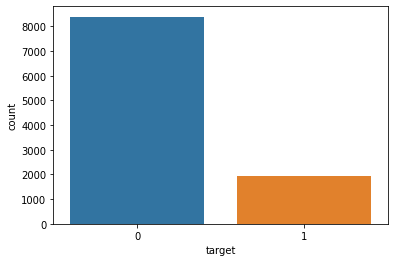

In [85]:
sns.countplot(x="target", data=clean_data)

ValueError: could not convert string to float: '햇빛만 쬐면 자동차 표면 흠집 사라진다'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


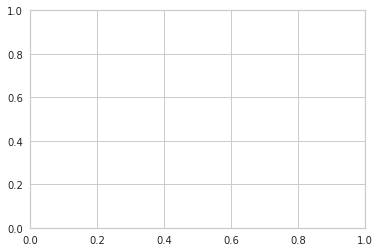

In [52]:
def pca_visualisation_2d(df_temp : pd.DataFrame, target_col : str) -> None:
    """
    Visualize 2d
    
    Parameters
    ----------
    df_temp : pd.DataFrame
        The dataframe to use features from for embedding
    target_col : str
        The target variable to be dropped from dataframe
    """
    if len(df_temp) > 3000:
        df_temp = df_temp.copy().sample(n=2999, random_state=1)
    y = df_temp[target_col]
    X = df_temp.drop(columns=[target_col])
    visualizer = yellowPCA(scale=True, projection=2, alpha=0.4)
    visualizer.fit_transform(X, y)
    visualizer.show()
    plt.show()

pca_visualisation_2d(clean_data, "target")